In [1]:
#Importing necessary libraries
import numpy as np
import keras
import matplotlib
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation
from tensorflow import keras
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.metrics import categorical_crossentropy
import warnings
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import optimizers as opt
from tensorflow.keras.optimizers import Adam

In [2]:
# Defining the path to directory of the data set.
train_path = r"C:/Users/visha/VGG/train"
validation_path = r"C:/Users/visha/VGG/validation"
test_path = r"C:/Users/visha/VGG/test"

# Data augmentation
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":75,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1,\
              "shear_range":0.1, \
              "zoom_range": [0.8,2.0],\
              "horizontal_flip":True,\
              "vertical_flip":False\
               }

# Generating train, validation and test batches using ImageDataGenerator.
train_batches = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224),\
                class_mode='categorical', batch_size=64, interpolation="nearest",shuffle=True)

validation_batches = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=validation_path, target_size=(224,224),\
                class_mode='categorical', batch_size=64, interpolation="nearest",shuffle=True)

test_batches = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path,  target_size=(224,224),\
                class_mode='categorical',  batch_size=64, interpolation="nearest", shuffle=True)


Found 8000 images belonging to 4 classes.
Found 1240 images belonging to 4 classes.
Found 1240 images belonging to 4 classes.


Actual label on a small set of test data--



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

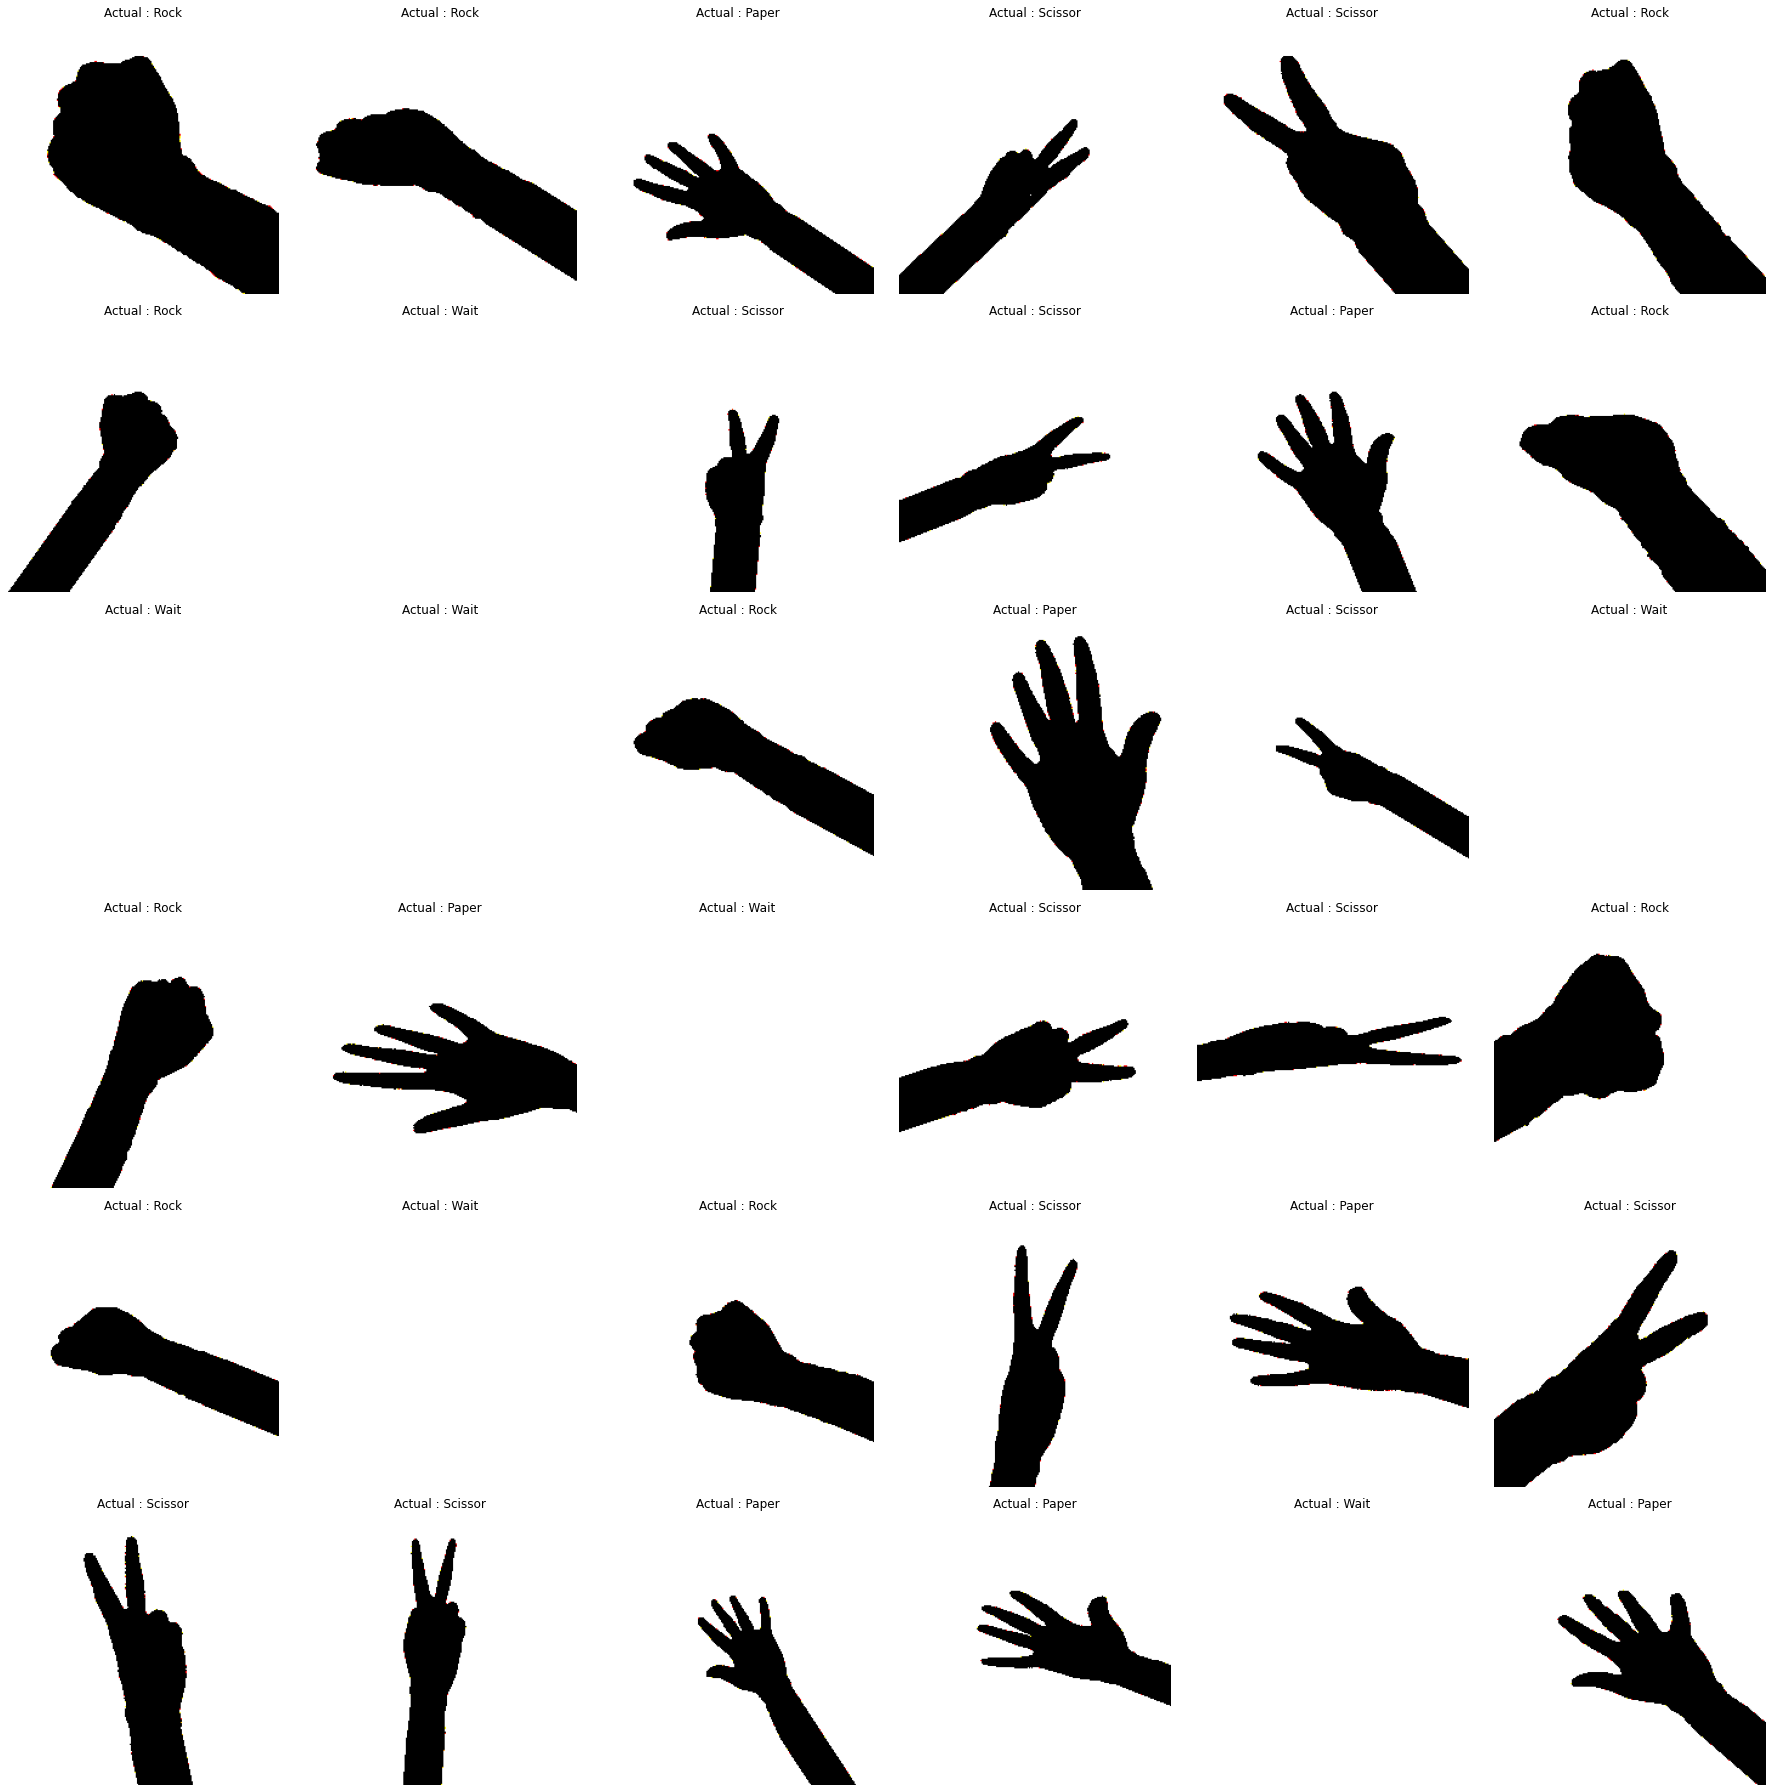

In [3]:
# Defining the labels to the image data-set
word_dict = {0:'Paper',1:'Rock',2:'Scissor',3:'Wait'}

# Getting a sample of train batches
imgs, labels = next(train_batches)

print("Actual label on a small set of test data--")
print("")

fig, axes = plt.subplots(6, 6, figsize=(25,25))
axes = axes.flatten()
count = 0

# Plotting the train sample data-set.
for img, ax in zip( imgs, axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Actual : %s" %(word_dict[np.argmax(labels[count])] ))  
    count = count + 1
plt.tight_layout()
plt.show()

In [4]:
# Defining the model name
model_name_it = "VGG_it.h5"   # Without fine tuning
model_name_ft = "VGG_ft.h5"   # After fine tuning

In [5]:
base_model = VGG16(
    weights='imagenet',         # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),  # Input shape of the image
    include_top=False)   
base_model.trainable = False    # Freezing the initian layers 

In [6]:
x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(10,activation = 'relu')(x2)
out = tf.keras.layers.Dense(4,activation = 'softmax')(x3)  # Four output classification.

model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Mode")
print(model.summary())

Initial Training Mode
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 10)                250890    
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 14,965,622
Trainable params: 250,934
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [7]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])  

# Reducing the learning rate by 50%.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)   

# Early stopping to prevent the overfitting
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min')  

# Saving the best fit model
monitor_it = ModelCheckpoint (model_name_it, monitor='val_loss', verbose=0, save_weights_only=False, mode='min')


In [8]:
# Training the model
history = model.fit(train_batches, epochs=20, verbose = 1,\
                    callbacks=[monitor_it, reduce_lr, early_stop],\
                    validation_data = validation_batches)

Epoch 1/20
125/125 [==============================] - 1218s 10s/step - loss: 0.3635 - accuracy: 0.7778 - val_loss: 0.0348 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 1195s 10s/step - loss: 0.0089 - accuracy: 0.9989 - val_loss: 0.0127 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 1175s 9s/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 0.0126 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 1137s 9s/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0030 - val_accuracy: 0.9992 - lr: 5.0000e-04
Epoch 5/20
125/125 [==============================] - 1140s 9s/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9984 - lr: 5.0000e-04
Epoch 6/20
125/125 [==============================] - 1134s 9s/step - loss: 8.3491e-04 - accuracy: 0.9999 - val_loss: 0.0099 - val_accuracy: 0.9976 - lr: 2.5000e-04


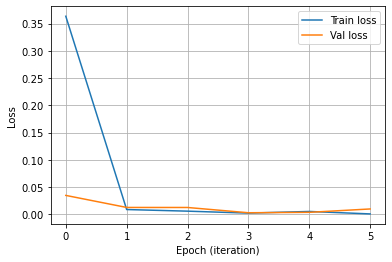

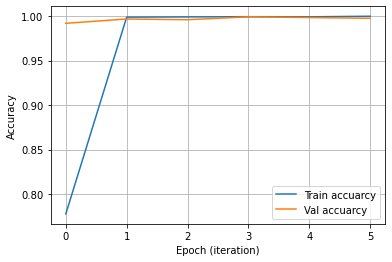

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history['accuracy'], label = "Train accuarcy")
plt.plot(history.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [10]:
model = tf.keras.models.load_model(model_name_it)
model.trainable = True    # Training whole model (Keeping it unfreeze)

model.compile(optimizer=Adam(learning_rate=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])

# Reducing the learning rate by 50%.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-10)

# Early stopping to prevent the overfitting
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='min')

# Saving the best fit model
monitor_ft = ModelCheckpoint (model_name_ft, monitor='val_loss', verbose=0, save_weights_only=False, mode='min')

print("Fine tuning model")
print(model.summary())

Fine tuning model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 10)                250890    
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 14,965,622
Trainable params: 14,965,622
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# Training the model for fine tuning
history = model.fit(train_batches, epochs=5, verbose = 1, callbacks=[monitor_ft, reduce_lr, early_stop],  validation_data = validation_batches)

Epoch 1/5
125/125 [==============================] - 4503s 36s/step - loss: 1.3281e-04 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9976 - lr: 1.0000e-08
Epoch 2/5
125/125 [==============================] - 2625s 21s/step - loss: 5.7312e-04 - accuracy: 0.9998 - val_loss: 0.0020 - val_accuracy: 0.9992 - lr: 1.0000e-08
Epoch 3/5
125/125 [==============================] - 2394s 19s/step - loss: 1.5049e-04 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 0.9984 - lr: 1.0000e-08
Epoch 4/5
125/125 [==============================] - 2381s 19s/step - loss: 6.3963e-04 - accuracy: 0.9998 - val_loss: 0.0132 - val_accuracy: 0.9960 - lr: 2.0000e-09


In [12]:
# For getting next batch of testing imgs...
imgs, labels = next(test_batches)

# Predicting the test data-set
predictions = model.predict(imgs, verbose=0)

# Evaluating the model score.
scores = model.evaluate(imgs, labels, verbose=0)

print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


loss of 0.00011444131087046117; accuracy of 100.0%


predictions on a small set of test data--



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

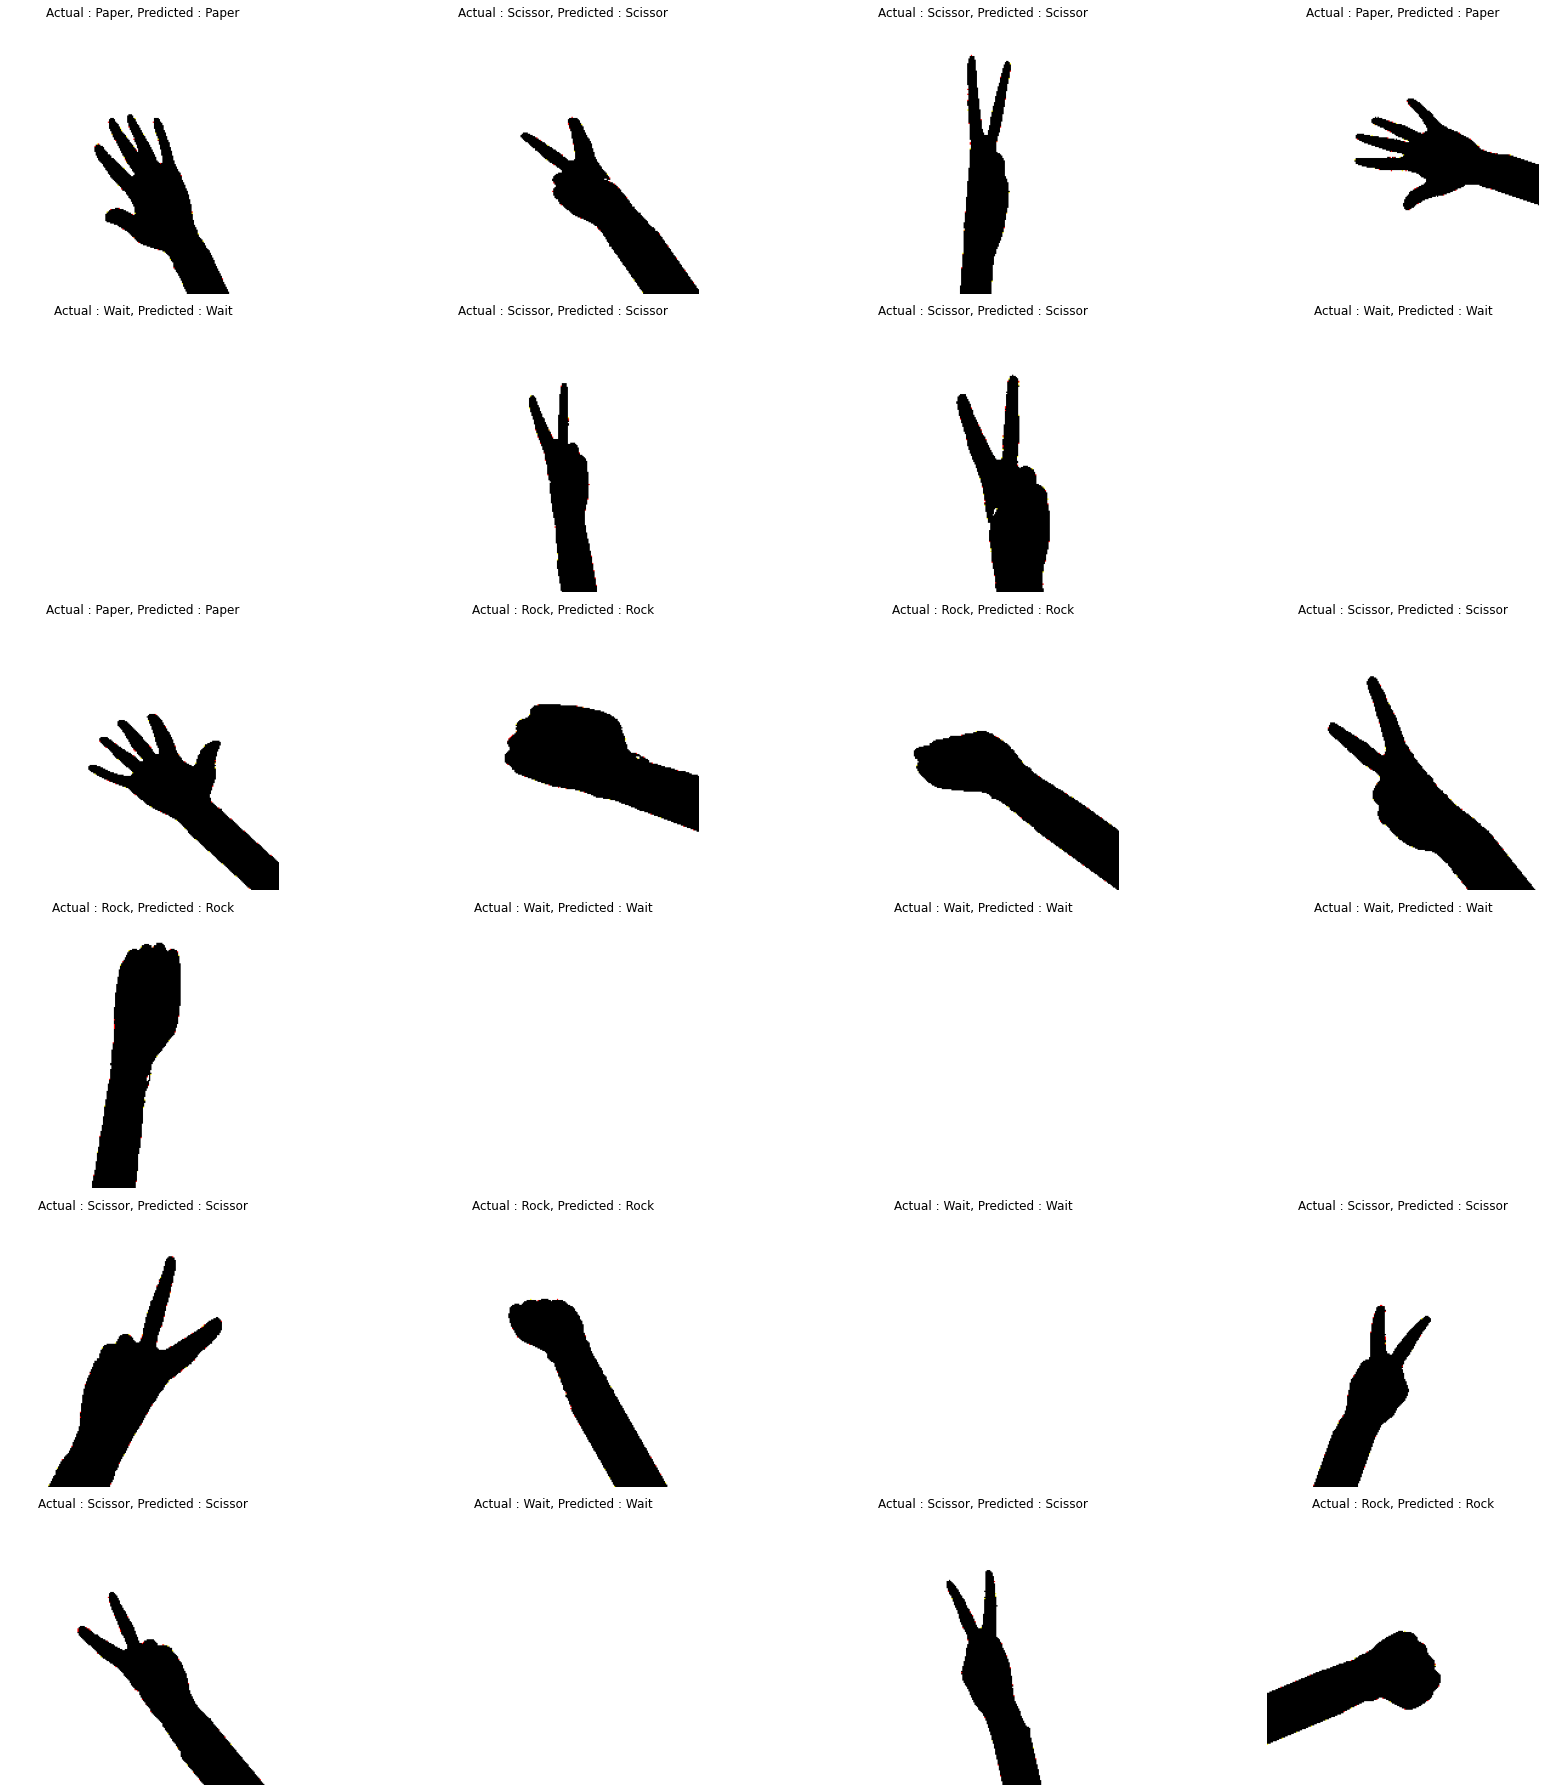

In [13]:
print("predictions on a small set of test data--")
print("")
fig, axes = plt.subplots(6, 4, figsize=(25,25))
axes = axes.flatten()
count = 0
i = np.array(predictions)

for img, ax in zip( imgs, axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Actual : %s, Predicted : %s" %(word_dict[np.argmax(labels[count])], word_dict[np.argmax(i[count])]))  #label[count]
    count = count + 1
plt.tight_layout()
plt.show()

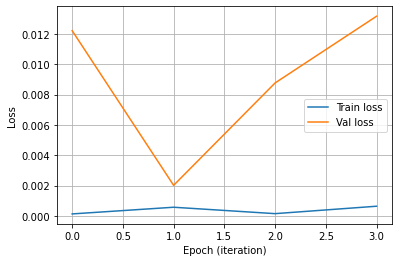

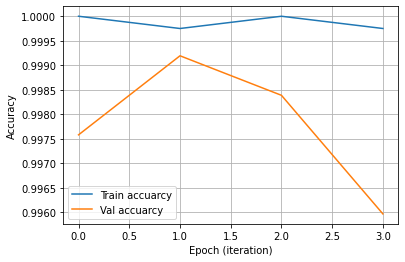

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history['accuracy'], label = "Train accuarcy")
plt.plot(history.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [20]:
# Importing necessary Libraries for Confusion matrix.
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import seaborn as sn
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [21]:
# Getting test batch from the datasets.
imgs, labels = next(test_batches)
model = keras.models.load_model(r"C:/Users/visha/VGG_ft.h5")

In [22]:
classes = labels.shape[1]
y_true=np.argmax(labels,axis=1)
yp = model.predict(imgs)
yp1=np.argmax(yp,axis=1)

In [23]:
cm = tf.math.confusion_matrix(labels=y_true,predictions=yp1)

Text(51.0, 0.5, 'Truth lable')

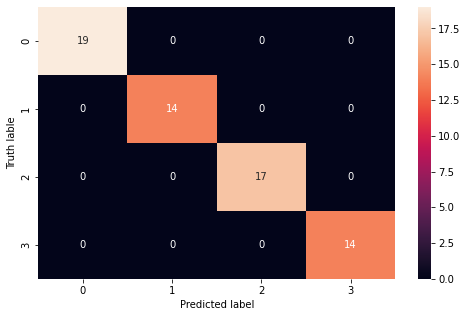

In [24]:
# Printing the confusion matrix.
plt.figure(figsize = (8,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('Truth lable')